# Autoencoder

Let's import modules required throughout this practice

In [213]:
from copy import deepcopy
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt



## Data
We will use MNIST dataset.

In [214]:
batch_size = 100

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_data = MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size, drop_last=True)
test_data = MNIST('data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size, drop_last=True)

train_b_imgs, train_b_lbs = next(iter(train_loader))
print(train_b_imgs.size())


torch.Size([100, 1, 28, 28])


## Model
Here, let's make a general autoencoder model.
According to Vincent (2008), simple autoencoder can be expressed like such, $ argmin_{\theta} \mathbb{E}[L(X, g(f(X))] $.
Later, we will make other types of autoencoders.

In [215]:
class AutoEncoder(nn.Module):
    def __init__(self, in_features, latent_features):
        super().__init__()
        self.encoder = nn.Linear(in_features, latent_features)
        self.decoder = nn.Linear(latent_features, in_features)
    
    def forward(self, x):
        # input in a shape of B x 1 x 28 x 28, B is a batch size
        output = x.view(-1, 784)            # shape B x 784
        output = self.encoder(output)       # shape B x L, L is latent features
        output = torch.sigmoid(output)
        output = self.decoder(output)       # shape B x 784
        output = torch.sigmoid(output)      
        output = output.view(-1, 1, 28, 28) # shape B x 1 x 28 x 28
        return output

## Train

Let's train and observe the result.

In [216]:
# set hyperparameters
epochs = 20
lr = 1e-3

model = AutoEncoder(784, 100)
criterion = nn.BCELoss()    # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                            # We will use Binary Cross Entropy loss as stated in the paper, Vincent (2008).
                            # Check the link out as it contains important implementation details
# criterion = nn.MSELoss()
# optim = torch.optim.SGD(model.parameters(), 1)
optim = torch.optim.Adam(model.parameters(), lr)         # for some reason, Adam optimization does so much better than SGD

state_dicts = []

for epoch in range(epochs):
    for i, batch in enumerate(train_loader):
        imgs, _ = batch     # We won't need labels in training autoencoders

        optim.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        loss.backward()
        optim.step()
    if epoch % 2 == 1:
        state_dicts.append(deepcopy(model.state_dict()))

    print(loss)

        


tensor(0.2285, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1844, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1603, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1448, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1332, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1238, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1162, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1102, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1055, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1018, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0989, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0964, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0943, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0923, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0903, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0880, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0855, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0832, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0814, grad_fn=<BinaryCrossEntropyBack

torch.Size([100, 1, 28, 28])
torch.Size([32, 152, 3])


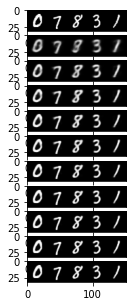

In [217]:
imgs, _ = next(iter(train_loader))
print(imgs.size())
img_grid = torchvision.utils.make_grid(imgs[-5:], nrow=5).permute(1, 2, 0)
print(img_grid.size())
plt.subplot(11, 1, 1)
plt.imshow(img_grid)

for i, state_dict in enumerate(state_dicts):
    model.load_state_dict(state_dict)
    output = model(imgs)
    output_grid = torchvision.utils.make_grid(output[-5:], 5).permute(1, 2, 0)
    plt.subplot(11, 1, i + 2)
    plt.imshow(output_grid.detach())
    if i == 9:
        break



One interesting thing to note from this activity is that Adam optimization performs far superior compared to SGD optimization. Let's try to grasp what features the model learns.

## Evaluation

Now, it will be good to evaluate the process.

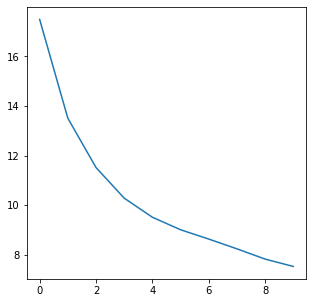

In [218]:
with torch.no_grad():
    total_loss = [0] * len(state_dicts)
    for i, state_dict in enumerate(state_dicts):
        model.load_state_dict(state_dict)
        for batch in test_loader:
            imgs, _ = batch
            output = model(imgs)
            loss = criterion(output, imgs)
            total_loss[i] += loss

plt.plot(np.arange(len(state_dicts)), total_loss)


As we see from the graph above, there is no overfitting happening from the training, so we will proceed with the last state of the training.

## Result

It is interesting to see the features taught during the training. I thing it will be interesting to see the timelapse of learned features.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])


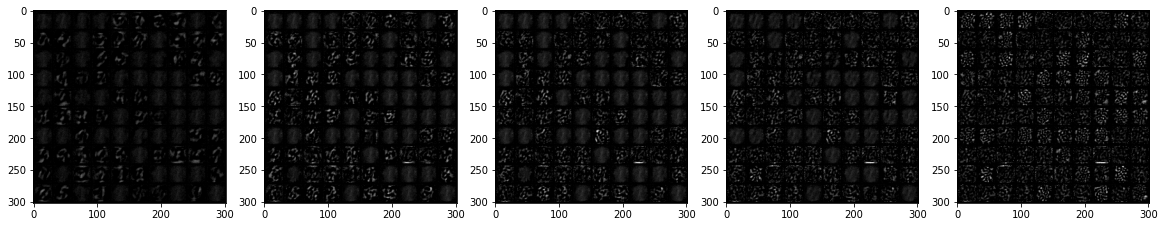

In [219]:
step = 2
plt.rcParams["figure.figsize"]=20,20

for i in range(len(state_dicts) // step):
    weight = state_dicts[step * i]['encoder.weight']
    print(weight.size())        # Shape 100 x 784
    weight = weight.view(-1, 1, 28, 28)     # Change shape to conform arg shape of make_grid, B x C x W x H
    plt.subplot(1, len(state_dicts) / step, i + 1)
    plt.imshow(torchvision.utils.make_grid(weight, nrow=10).permute(1, 2, 0))


# Denoising Autoencoder

## Model

Vincet (2008) introduced denoising autoencoders to perform an autoencoder __"robust to partial destruction of the input"__. It simply is implemented via masking input stochastically during training.

$$ argmin_{\theta} \mathbb{E}[L(X, g(f(\tilde{X}))] $$
Although very similar to the goal of original autoencoder, note that the model aims to reconstruct from masked input.

In [220]:
class DenoisedAutoEncoder(nn.Module):
    def __init__(self, in_features, latent_features, proportion):
        super().__init__()
        self.in_features = in_features
        self.encoder = nn.Linear(in_features, latent_features)
        self.decoder = nn.Linear(latent_features, in_features)
        self.mask = self.create_mask(proportion)    # proportion of input destruction
    
    def forward(self, x):
        # input in a shape of B x 1 x 28 x 28, B is a batch size
        output = x.view(-1, 784)            # shape B x 784
        if self.training:                   # destruct input by masking only during training
            output = output.masked_fill(self.mask, 0)   
        output = self.encoder(output)       # shape B x L, L is latent features
        output = torch.sigmoid(output)
        output = self.decoder(output)       # shape B x 784
        output = torch.sigmoid(output)      
        output = output.view(-1, 1, 28, 28) # shape B x 1 x 28 x 28
        return output

    def create_mask(self, proportion):
        k = int(self.in_features * proportion)
        idx = random.sample(list(range(self.in_features)), k)
        mask = torch.zeros(self.in_features).bool()
        mask[idx] = True
        return mask

Destructing input by masking is an important detail to note. It is crucial to note denoising only occurs during training. It will be good to visualize what masking is actually doing.

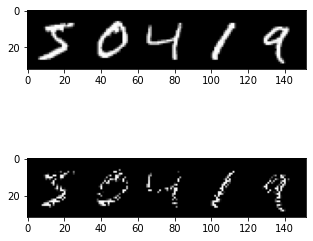

In [224]:
plt.rcParams["figure.figsize"]=5, 5
imgs, _ = next(iter(train_loader))

model = DenoisedAutoEncoder(784, 100, proportion=0.5)
mask = model.create_mask(0.5)
masked_imgs = imgs.view(-1, 784)
masked_imgs = masked_imgs.masked_fill(mask, 0).view(-1, 1, 28, 28)

imgs = torchvision.utils.make_grid(imgs[:5], 5)
masked_imgs = torchvision.utils.make_grid(masked_imgs[:5], 5)

plt.subplot(2, 1 ,1)
plt.imshow(imgs.permute(1, 2, 0))
plt.subplot(2, 1 ,2)
plt.imshow(masked_imgs.permute(1, 2, 0))

## Train

Now, let's train the model.

In [225]:
# set hyperparameters
epochs = 20
lr = 1e-3
mask_proportion = 0.5

model = DenoisedAutoEncoder(784, 100, mask_proportion)
criterion = nn.BCELoss()    # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                            # We will use Binary Cross Entropy loss as stated in the paper, Vincent (2008).
                            # Check the link out as it contains important implementation details
# criterion = nn.MSELoss()
# optim = torch.optim.SGD(model.parameters(), 1)
optim = torch.optim.Adam(model.parameters(), lr)         # for some reason, Adam optimization does so much better than SGD

state_dicts = []

model.train()

for epoch in range(epochs):
    for i, batch in enumerate(train_loader):
        imgs, _ = batch     # We won't need labels in training autoencoders

        optim.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        loss.backward()
        optim.step()
    if epoch % 2 == 1:
        state_dicts.append(deepcopy(model.state_dict()))

    print(loss)

tensor(0.2235, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1815, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1571, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1404, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1199, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1134, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1083, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1046, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1016, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0993, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0974, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0957, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0944, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0931, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0920, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0910, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0901, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0892, grad_fn=<BinaryCrossEntropyBack

Similar to what we did for autoencoder, let's look at the progress of reconstruction throughout training.

torch.Size([100, 1, 28, 28])
torch.Size([32, 152, 3])


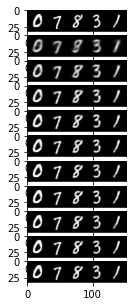

In [226]:
model.eval()

imgs, _ = next(iter(train_loader))
print(imgs.size())
img_grid = torchvision.utils.make_grid(imgs[-5:], nrow=5).permute(1, 2, 0)
print(img_grid.size())
plt.subplot(11, 1, 1)
plt.imshow(img_grid)

for i, state_dict in enumerate(state_dicts):
    model.load_state_dict(state_dict)
    output = model(imgs)
    output_grid = torchvision.utils.make_grid(output[-5:], 5).permute(1, 2, 0)
    plt.subplot(11, 1, i + 2)
    plt.imshow(output_grid.detach())
    if i == 9:
        break

## Evaluation

Let's evaluate if the trained model overfits to our training data.

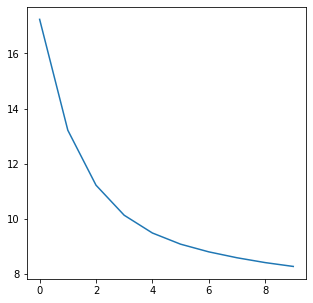

In [227]:
with torch.no_grad():
    total_loss = [0] * len(state_dicts)
    for i, state_dict in enumerate(state_dicts):
        model.load_state_dict(state_dict)
        for batch in test_loader:
            imgs, _ = batch
            output = model(imgs)
            loss = criterion(output, imgs)
            total_loss[i] += loss

plt.plot(np.arange(len(state_dicts)), total_loss)


We see that the model did not overfit and last training epoch resulted in the best result.

## Result

Lastly, let's closely look at the intermediate features taught during the training. Although it may be not too obvious, you can see the features trained with denoising autoencoder percieves better features like strockes compared to the features trained with an original autoencoder.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])
torch.Size([100, 784])


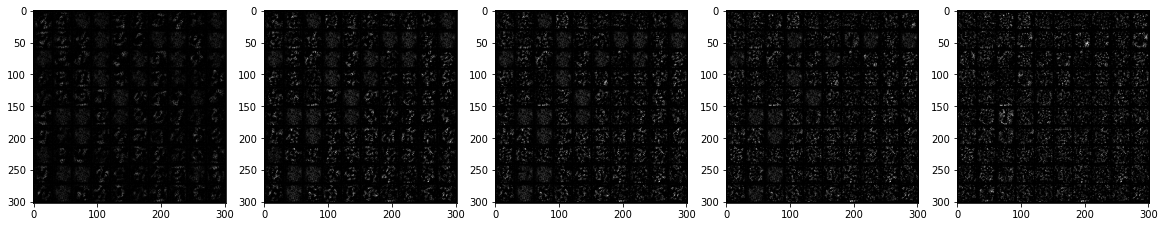

In [229]:
step = 2
plt.rcParams["figure.figsize"]=20,20

for i in range(len(state_dicts) // step):
    weight = state_dicts[step * i]['encoder.weight']
    print(weight.size())        # Shape 100 x 784
    weight = weight.view(-1, 1, 28, 28)     # Change shape to conform arg shape of make_grid, B x C x W x H
    plt.subplot(1, len(state_dicts) / step, i + 1)
    plt.imshow(torchvision.utils.make_grid(weight, nrow=10).permute(1, 2, 0))
